In [1]:
from dtw import dtw, accelerated_dtw
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import random
import itertools
import os

c:\programdata\miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [25]:
def _scale_uts(uts, scaler="minmax"):
    if scaler == "minmax":
        return preprocessing.minmax_scale(uts) + 0.1
    elif scaler == "none":
        return uts
    else:
        return preprocessing.scale(uts)
    
def _sign(v):
    if v == 0:
        return 0
    else:
        return np.sign(v)

class PTA(object):
    def __init__(self, uts, times=None, scaler="minmax"):
        self.uts = _scale_uts(uts, scaler=scaler)
        if times is None:
            times = np.arange(len(uts))
        self.times = times
        self.avg_rate = self.avg_sampling_rate()
        self.segments = []
        self.pta = []
        self.pta_times = []
        self.local_trend = []
        
    def clear(self):
        self.segments = []
        self.pta = []
        self.pta_times = []
        self.local_trend = []
        
    def diff_sampling_time(self):
        return np.array(self.times)[1:] - np.array(self.times)[:-1]
        
    def avg_sampling_rate(self):
        diff_time = self.diff_sampling_time()
        return np.mean(diff_time)
    
    def is_gap(self, i):
        return (self.times[i] - self.times[i-1]) > 3*self.avg_rate
        
    def compute_local_trend(self):
        self.local_trend = [[(self.uts[i] - self.uts[i-1]) / self.uts[i-1], i] for i in range(1, len(self.uts))]
        
    def segmentate(self, threshold=0.0, skip_gaps=False):
        seg_ini = 0
        seg_end = self.local_trend[0][1]
        sign = _sign(self.local_trend[0][0])
        l = len(self.local_trend)
        for i in range(1, l):
            trend_value, trend_i = self.local_trend[i]
            trend_sign = _sign(trend_value)
            if self.is_gap(trend_i):
                self.segments.append([seg_ini, seg_end])
                if skip_gaps:
                    seg_ini = trend_i
                    sign = 0
                else:
                    self.segments.append([seg_end, trend_i])
                    seg_ini = trend_i
                    sign = 0
            else:
                if sign == 0:
                    seg_end = trend_i
                    sign = trend_sign
                    if i == l - 1:
                        self.segments.append([seg_ini, seg_end])
                
                elif sign == trend_sign:
                    seg_end = trend_i
                    if i == l - 1:
                        self.segments.append([seg_ini, seg_end])
                else:
                    if np.abs(trend_value) <= threshold:
                        seg_end = trend_i
                        if i == l -1:
                            self.segments.append([seg_ini, seg_end])
                    else:
                        self.segments.append([seg_ini, seg_end])
                        seg_ini = seg_end
                        seg_end = trend_i
                        sign = trend_sign
                
    
    def segmentate_old(self, threshold=0.0):
        seg_ini = 0
        seg_end = self.local_trend[0][1]
        sign = _sign(self.local_trend[0][0])
        l = len(self.local_trend)
        for i in range(1, l):
            trend_value, trend_i = self.local_trend[i]
            trend_sign = _sign(trend_value)
            if sign == 0:
                seg_end = trend_i
                sign = trend_sign
                if i == l - 1:
                    self.segments.append([seg_ini, seg_end])
                    
            if sign == trend_sign:
                seg_end = trend_i
                if i == l - 1:
                    self.segments.append([seg_ini, seg_end])
            else:
                if np.abs(trend_value) <= threshold:
                    seg_end = trend_i
                    if i == l -1:
                        self.segments.append([seg_ini, seg_end])
                else:
                    self.segments.append([seg_ini, seg_end])
                    seg_ini = seg_end
                    seg_end = trend_i
                    sign = trend_sign
        
    def approximate(self):
        for i in range(len(self.segments)):
            ini, end = self.segments[i]
            R = (self.uts[end] - self.uts[ini]) / self.uts[ini]
            R_t = self.times[end]
            self.pta.append(R)
            self.pta_times.append(R_t)
    
    def get_dimensionaly_reduced(self):
        indexes = []
        for i in range(len(self.segments)):
            ini, end = self.segments[i]
#             indexes.append(ini)
            indexes.append(end)
        if 0 not in indexes:
            indexes.append(0)
        if len(self.uts)-1 not in indexes:
            indexes.append(len(self.uts) -1)
        indexes = sorted(indexes)
        reduced_uts = [self.uts[i] for i in indexes]
        reduced_times = [self.times[i] for i in indexes]
        return reduced_uts, reduced_times
    
def pta_pipeline(uts, times=None, scaler="minmax", threshold=0.0):
    pta = PTA(uts, times=times, scaler=scaler)
    pta.compute_local_trend()
    pta.segmentate(threshold=threshold)
    pta.approximate()
    return np.array(pta.pta), np.array(pta.pta_times)
#     r_uts, r_times = pta.get_dimensionaly_reduced()
#     return np.array(r_uts), np.array(r_times)
        
def transform_dataset(dataset, times_set=None, scaler="minmax", threshold=0.0):
    pta_dataset = []
    pta_times_set = []
    for i in range(len(dataset)):
        uts = dataset[i]
        times = times_set[i] if times_set is not None else None
        pta_uts, pta_times = pta_pipeline(uts, times=times, scaler=scaler, threshold=threshold)
        pta_dataset.append(pta_uts)
        pta_times_set.append(pta_times)
    return pta_dataset, pta_times_set

## Simple test 1: FaceFour dataset

The brute force 1NN classification accuracy for FaceFour is 84%

24 88


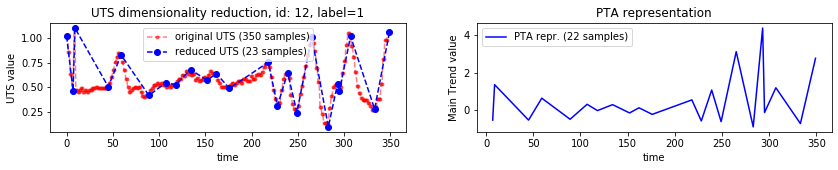

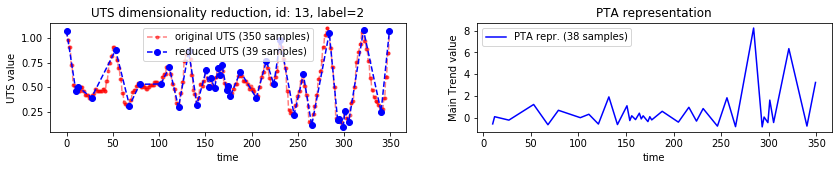

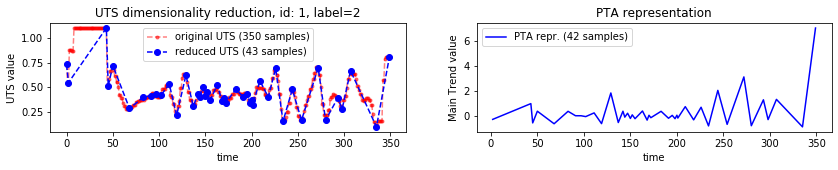

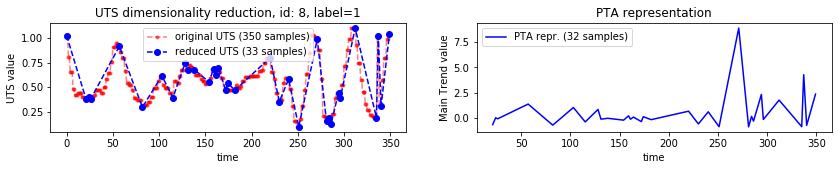

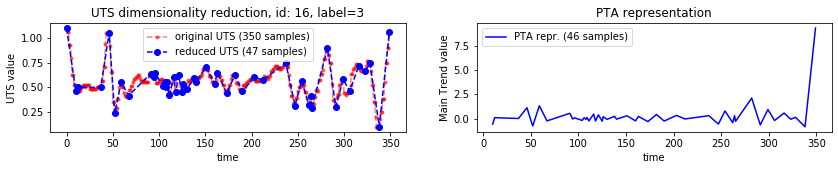

In [20]:
def facefour_data():
    train_file = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TRAIN.tsv"
    test_file = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TEST.tsv"

    file = open(train_file, 'r')
    lines = file.readlines()
    dataset = []
    labels = []
    for d in lines:
        arr = d[:-1].split('\t')
        y = np.array(arr[1:], dtype=float)
        labels.append(arr[0])
        dataset.append(y)

    file_t = open(test_file, 'r')
    lines_t = file_t.readlines()
    test = []
    l_test = []
    for d in lines_t:
        arr = d[:-1].split('\t')
        y = np.array(arr[1:], dtype=float)
        test.append(y)
        l_test.append(arr[0])
        
    print(len(labels), len(l_test))
    
    random.seed(0)
    j_arr = random.sample(range(len(dataset)), 5)
    
    for j in j_arr:
        uts = dataset[j]
        pta = PTA(uts)
        pta.clear()
        pta.compute_local_trend()
        pta.segmentate(threshold=0.05)
        pta.approximate()
        r_uts, r_times = pta.get_dimensionaly_reduced()
        fig, ax = plt.subplots(1, 2, figsize=(14, 2))
        ax[0].plot(pta.times, pta.uts, '.--', color="r", alpha=0.5, label="original UTS (%d samples)" % len(uts))
        ax[0].plot(r_times, r_uts, "o--", color="b", label="reduced UTS (%d samples)" % len(r_uts))
        ax[1].plot(pta.pta_times, pta.pta, color="b", label="PTA repr. (%d samples)" % len(pta.pta))
        ax[0].set_title("UTS dimensionality reduction, id: %s, label=%s" % (j, labels[j]))
        ax[1].set_title("PTA representation")
        ax[0].legend()
        ax[1].legend()
        ax[0].set_xlabel("time")
        ax[1].set_xlabel("time")
        ax[0].set_ylabel("UTS value")
        ax[1].set_ylabel("Main Trend value")
    return dataset, test, labels, l_test

ff_d_train, ff_d_test, ff_l_train, ff_l_test = facefour_data()

In [74]:
%%time
pta_ff_d_train, pta_ff_t_train = transform_dataset(ff_d_train, threshold=0.01)
pta_ff_d_test, pta_ff_t_test = transform_dataset(ff_d_test, threshold=0.01)

Wall time: 128 ms


In [32]:
def distance_matrix(X_train, X_test):
    # compute distances between each time series on test set and train set
    n = len(X_train)
    m = len(X_test)
    res = np.ones((n, m)) * -1
    for i in range(n):
        if i % 25 == 0:
            print("%d/%d" % (i, n), end="\r")
        for j in range(m):
            d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(X_train[i], X_test[j], 'euclidean')
            res[i][j] = d
    return res

In [44]:
%%time
dmatrix_pta = distance_matrix(pta_ff_d_train, pta_ff_d_test)

Wall time: 11.7 s


In [34]:
def classify_1nn(dmatrix, l_train, l_test):
    pred_labels = []
    n = len(l_train)
    m = len(l_test)
    for j in range(m):
        dmin = np.inf
        mink = -1
        for i in range(n):
            if dmatrix[i][j] < dmin:
                dmin = dmatrix[i][j]
                mink = i
#         print(mink, i)
        pred_labels.append(l_train[mink])
    
    balanced_acc = balanced_accuracy_score(l_test, pred_labels)
    acc = accuracy_score(l_test, pred_labels)
    print("1NN classification -> acc: {}, balanced_acc: {}".format(round(acc, 3), round(balanced_acc, 3)))
    return pred_labels
            


In [ ]:
pred_labels = classify_1nn(dmatrix_pta, ff_l_train, ff_l_test)

### Simple 2: ControlChart dataset

according to PTA papper, PTA has 98.7% accuracy on this dataset, compared to 95,2% using PAA and 96,4% using APCA. They dont give the threshold value (just say "threshold need to be predefined").

Their experiment is based on 1NN classification from leave-one-out cross validation, so its 98.7% accuracy is from cross validation process.

They also claim to use smoothing techniques on the time series, but we wont use that for our experiments

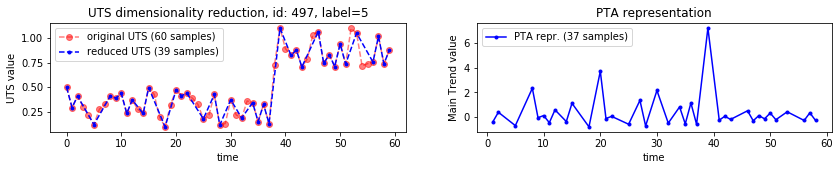

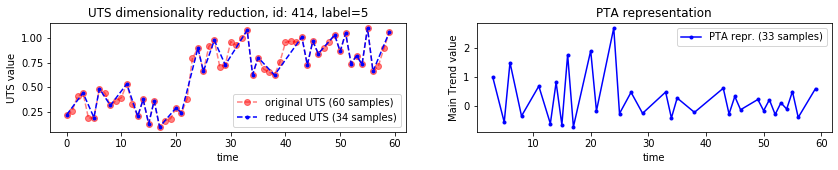

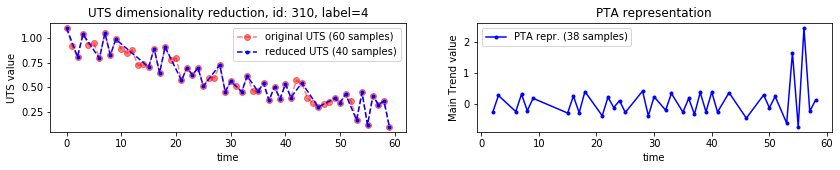

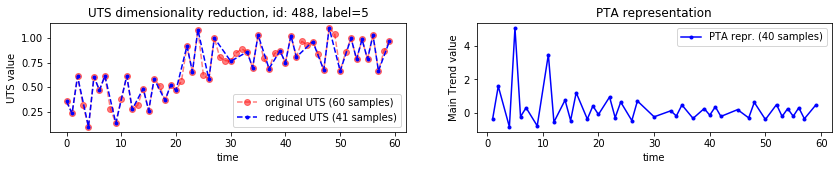

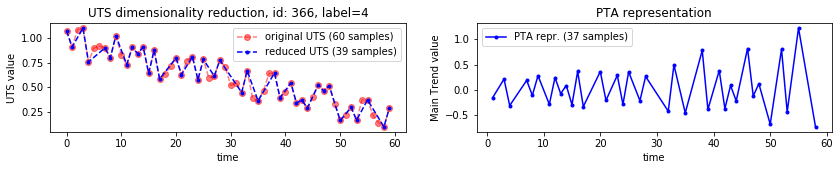

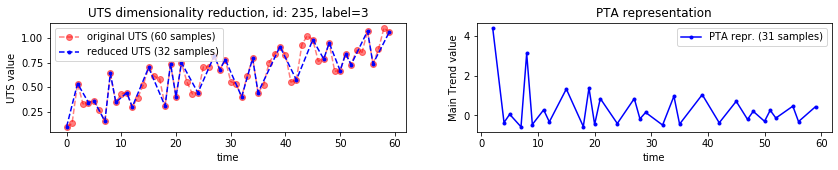

In [21]:
def control_chart_data():
    file_path = "D:/tesis/tesis/data/synthetic_control.data"
    file = open(file_path, 'r')
    lines = file.readlines()
    dataset = []
    labels = []
    class_number = 0
    for i, d in enumerate(lines):
        if i % 100 == 0:
            class_number += 1     
        arr = d[:-1].split()
        y = np.array(arr, dtype=float)
        labels.append(class_number)
        dataset.append(y)
    
    j_arr = random.sample(range(len(dataset)), 5)
    j_arr.append(235)
    
    for j in j_arr:
        uts = dataset[j]
        pta = PTA(uts)
        pta.clear()
        pta.compute_local_trend()
        pta.segmentate(threshold=0.05)
        pta.approximate()
        r_uts, r_times = pta.get_dimensionaly_reduced()
        fig, ax = plt.subplots(1, 2, figsize=(14, 2))
        ax[0].plot(pta.times, pta.uts, 'o--', color="r", alpha=0.5, label="original UTS (%d samples)" % len(uts))
        ax[0].plot(r_times, r_uts, ".--", color="b", label="reduced UTS (%d samples)" % len(r_uts))
        ax[1].plot(pta.pta_times, pta.pta, '.-', color="b", label="PTA repr. (%d samples)" % len(pta.pta))
        ax[0].set_title("UTS dimensionality reduction, id: %s, label=%s" % (j, labels[j]))
        ax[1].set_title("PTA representation")
        ax[0].legend()
        ax[1].legend()
        ax[0].set_xlabel("time")
        ax[1].set_xlabel("time")
        ax[0].set_ylabel("UTS value")
        ax[1].set_ylabel("Main Trend value")
    return dataset, labels
        
cc_dataset, cc_labels = control_chart_data()

In [134]:
%%time
pta_cc_dataset, pta_cc_times = transform_dataset(cc_dataset, threshold=0.05)

Wall time: 217 ms


In [135]:
%%time
dmatrix_cc = distance_matrix(pta_cc_dataset, pta_cc_dataset)

Wall time: 13min 2s


In [148]:
# save dmatrix_cc since takes time to compute
np.save("D:/tesis/tesis/data/control_chart_dmatrix.npy", dmatrix_cc)

In [149]:
# and load it
dmatrix_pta_cc = np.load("D:/tesis/tesis/data/control_chart_dmatrix.npy", allow_pickle=True)

In [150]:
def leave_one_out_cv(dmatrix, dataset, labels):
    pred_labels = []
    n = len(dataset)
    for i in range(n):
        idxs = np.argsort(dmatrix[i])
        if idxs[0] == i:
            idx_min = idxs[1]
        else:
            raise ValueError("there is a big problem here")
        pred_labels.append(labels[idx_min])
    
    balanced_acc = balanced_accuracy_score(labels, pred_labels)
    acc = accuracy_score(labels, pred_labels)
    print("1NN classification -> acc: {}, balanced_acc: {}".format(round(acc, 3), round(balanced_acc, 3)))
    return pred_labels

pred_labels = leave_one_out_cv(dmatrix_pta_cc, pta_cc_dataset, cc_labels)

1NN classification -> acc: 0.868, balanced_acc: 0.868


### Algorithm: PTA Fixed

PTA paper claims the algorithm to be linear with the length of original time series, but in worst case, the algorithm will be the same as brute force classifier which takes quadratic time using DTW distance.

My adaptation to fix this problem is to choose threshold $\epsilon$ such that the residual number of segments (samples in the PTA representation) is less or equal to a fixed number ($max\_size$).

since bigger $\epsilon$ means smaller PTA representation, we start the search from 0 epislon and we look in steps of 0.05 until we reach the desired PTA size. This means at most 18 extra iterations on each time series, which is a fixed number and doesnt affect the time complexity. On the other hand, having fixed size PTA representations will means that distance computation using DTW will be $O(max\_size^2)$ on the worst case, with $max\_size < n$ and fixed.

In [59]:
class PTAFixed(PTA):
    def __init__(self, uts, times=None, scaler="minmax"):
        super().__init__(uts, times=times, scaler=scaler)
        self.threshold=0.0
    
    def segmentate_fixed(self, max_size, skip_gaps=False):
        threshold_ini = 0.0
        threshold_end = 0.9
        threshold_step = 0.05
        threshold_values = threshold_ini + np.arange(int((threshold_end - threshold_ini) / threshold_step) + 1) * threshold_step
        for threshold in threshold_values:
            self.segments = []
            self.segmentate(threshold=threshold, skip_gaps=skip_gaps)
            if len(self.segments) <= max_size:
                self.threshold = threshold
                break
                
def pta_fixed_pipeline(uts, times=None, scaler="minmax", max_size=20, skip_gaps=False):
    pta = PTAFixed(uts, times=times, scaler=scaler)
    pta.compute_local_trend()
    pta.segmentate_fixed(max_size, skip_gaps=skip_gaps)
    pta.approximate()
    return np.array(pta.pta), np.array(pta.pta_times)
#     r_uts, r_times = pta.get_dimensionaly_reduced()
#     return np.array(r_uts), np.array(r_times)
        
def transform_dataset_pta_fixed(dataset, times_set=None, scaler="minmax", max_size=20, skip_gaps=False):
    pta_dataset = []
    pta_times_set = []
    for i in range(len(dataset)):
        uts = dataset[i]
        times = times_set[i] if times_set is not None else None
        pta_uts, pta_times = pta_fixed_pipeline(uts, times=times, scaler=scaler, max_size=max_size, skip_gaps=skip_gaps)
        pta_dataset.append(pta_uts)
        pta_times_set.append(pta_times)
    return pta_dataset, pta_times_set

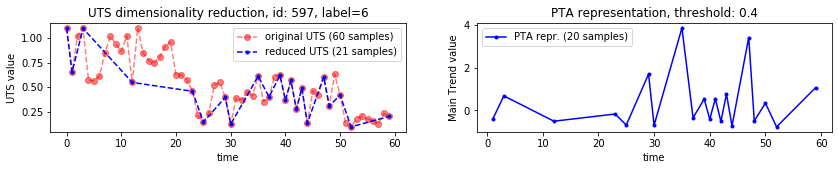

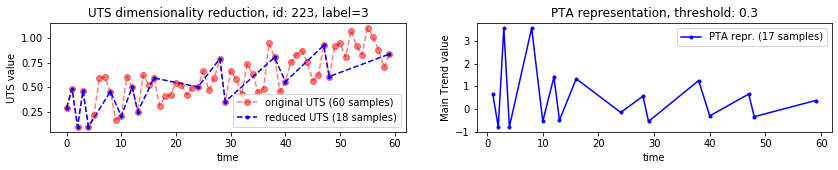

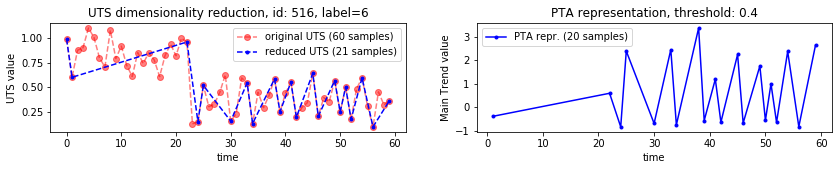

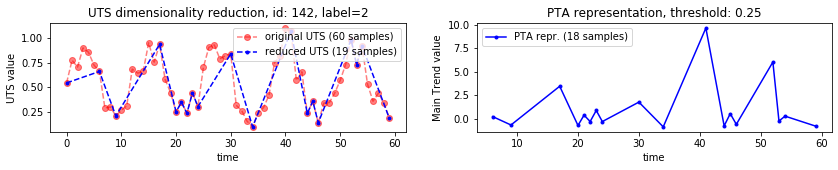

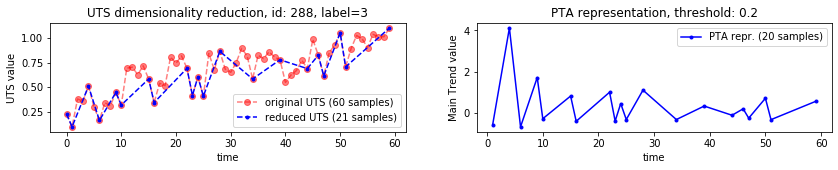

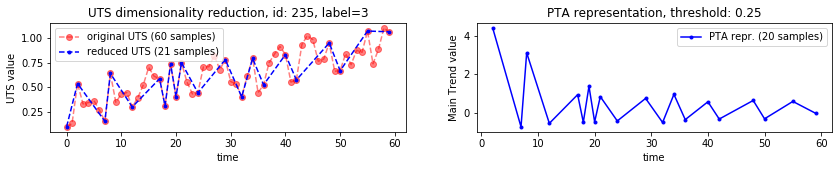

In [23]:
def plot_pta_fixed(dataset, labels, max_size=20):
    j_arr = random.sample(range(len(dataset)), 5)
    j_arr.append(235)
    
    for j in j_arr:
        uts = dataset[j]
        pta = PTAFixed(uts)
        pta.clear()
        pta.compute_local_trend()
        pta.segmentate_fixed(max_size)
        pta.approximate()
        r_uts, r_times = pta.get_dimensionaly_reduced()
        fig, ax = plt.subplots(1, 2, figsize=(14, 2))
        ax[0].plot(pta.times, pta.uts, 'o--', color="r", alpha=0.5, label="original UTS (%d samples)" % len(uts))
        ax[0].plot(r_times, r_uts, ".--", color="b", label="reduced UTS (%d samples)" % len(r_uts))
        ax[1].plot(pta.pta_times, pta.pta, '.-', color="b", label="PTA repr. (%d samples)" % len(pta.pta))
        ax[0].set_title("UTS dimensionality reduction, id: %s, label=%s" % (j, labels[j]))
        ax[1].set_title("PTA representation, threshold: " + str(round(pta.threshold, 2)))
        ax[0].legend()
        ax[1].legend()
        ax[0].set_xlabel("time")
        ax[1].set_xlabel("time")
        ax[0].set_ylabel("UTS value")
        ax[1].set_ylabel("Main Trend value")

plot_pta_fixed(cc_dataset, cc_labels, max_size=20)

In [161]:
%%time
pta_cc_dataset, pta_cc_times = transform_dataset_pta_fixed(cc_dataset, max_size=20)

Wall time: 695 ms


In [162]:
%%time
dmatrix_cc = distance_matrix(pta_cc_dataset, pta_cc_dataset)

Wall time: 4min 3s


In [163]:
pred_labels = leave_one_out_cv(dmatrix_pta_cc, pta_cc_dataset, cc_labels)

1NN classification -> acc: 0.868, balanced_acc: 0.868


We should apply a grid search on $max\_size$ parameter to see if we can reach 98.7% cross validation accuracy. Which we will do using multiprocessing from terminal for faster execution

In [164]:
# need to get the results of grid search on max_size parameter

### Experiment on PLaSTiCC subsets

Using our PTA Fixed, we will evaluate performance and time execution on PLaSTiCC subsets DDF/WDF

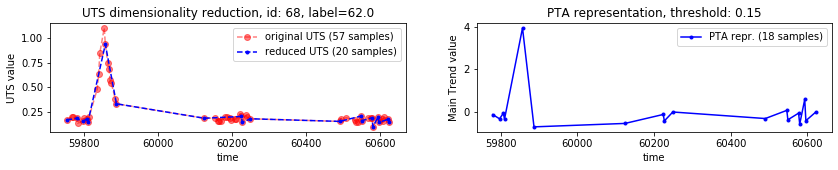

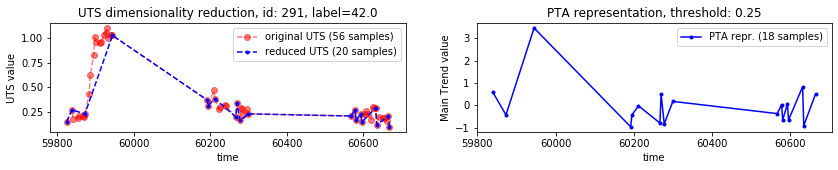

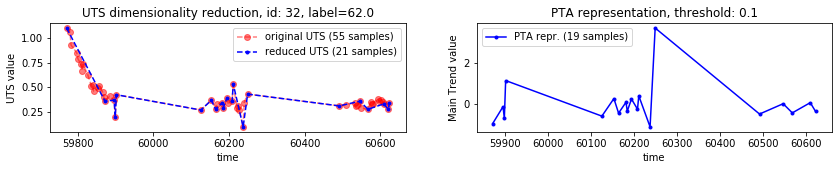

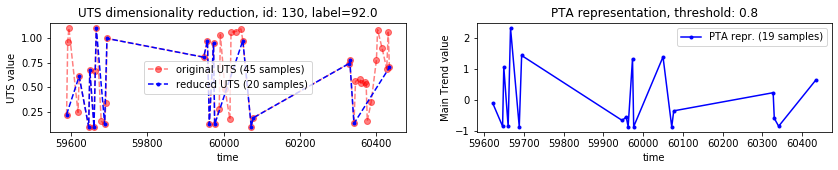

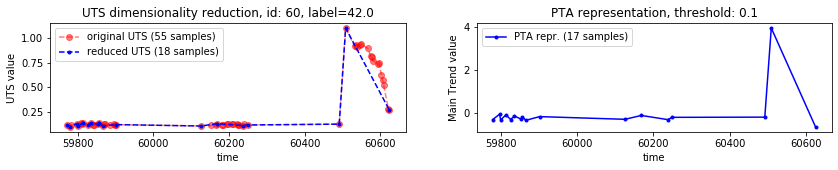

In [77]:

def plasticc_data(_type):
    main_path = os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), '..'))
    data_path = os.path.join(main_path, "data", "plasticc_subsets", "ddf_wdf_split_min_detection", "3_min")
    train_base = _type + "_train_%s.npy"
    test_base = _type + "_test_%s.npy"

    train_dataset = np.load(os.path.join(data_path, train_base % "d"), allow_pickle=True)
    train_times = np.load(os.path.join(data_path, train_base % "t"), allow_pickle=True)
    train_labels = np.load(os.path.join(data_path, train_base % "l"), allow_pickle=True)

    test_dataset = np.load(os.path.join(data_path, test_base % "d"), allow_pickle=True)
    test_times = np.load(os.path.join(data_path, test_base % "t"), allow_pickle=True)
    test_labels = np.load(os.path.join(data_path, test_base % "l"), allow_pickle=True)
    
    random.seed(1)
    j_arr = random.sample(range(len(train_dataset)), 5)
#     j_arr = np.argsort(train_labels)[300:305]
    max_size = 20
    skip_gaps=False
    
    for j in j_arr:
        uts = train_dataset[j]
        times = train_times[j]
        pta = PTAFixed(uts, times=times, scaler="minmax")
        pta.clear()
        pta.compute_local_trend()
        pta.segmentate_fixed(max_size, skip_gaps=skip_gaps)
        pta.approximate()
        r_uts, r_times = pta.get_dimensionaly_reduced()
        fig, ax = plt.subplots(1, 2, figsize=(14, 2))
        ax[0].plot(pta.times, pta.uts, 'o--', color="r", alpha=0.5, label="original UTS (%d samples)" % len(uts))
        ax[0].plot(r_times, r_uts, ".--", color="b", label="reduced UTS (%d samples)" % len(r_uts))
        scaled_pta = preprocessing.scale(pta.pta)
        ax[1].plot(pta.pta_times, scaled_pta, '.-', color="b", label="PTA repr. (%d samples)" % len(pta.pta))
#         ax[2].hist(pta.diff_sampling_time())
        ax[0].set_title("UTS dimensionality reduction, id: %s, label=%s" % (j, train_labels[j]))
        ax[1].set_title("PTA representation, threshold: " + str(round(pta.threshold, 2)))
        ax[0].legend()
        ax[1].legend()
        ax[0].set_xlabel("time")
        ax[1].set_xlabel("time")
        ax[0].set_ylabel("UTS value")
        ax[1].set_ylabel("Main Trend value")
        
    return train_dataset, test_dataset, train_times, test_times, train_labels, test_labels
        

p_train_d, p_test_d, p_train_t, p_test_t, p_train_l, p_test_l = plasticc_data("ddf")

In [75]:
%%time
max_size = 30
skip_gaps = False
pta_p_train_d, pta_p_train_t = transform_dataset_pta_fixed(p_train_d, times_set=p_train_t, 
                                                           max_size=max_size, skip_gaps=skip_gaps)
pta_p_test_d, pta_p_test_t = transform_dataset_pta_fixed(p_test_d, times_set=p_test_t, 
                                                         max_size=max_size, skip_gaps=skip_gaps)

Wall time: 393 ms


In [76]:
%%time
dmatrix_plasticc = distance_matrix(pta_p_train_d, pta_p_test_d)

Wall time: 1min 42s


In [73]:
pred_labels = classify_1nn(dmatrix_plasticc, p_train_l, p_test_l)

1NN classification -> acc: 0.507, balanced_acc: 0.539


In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

Confusion matrix, without normalization


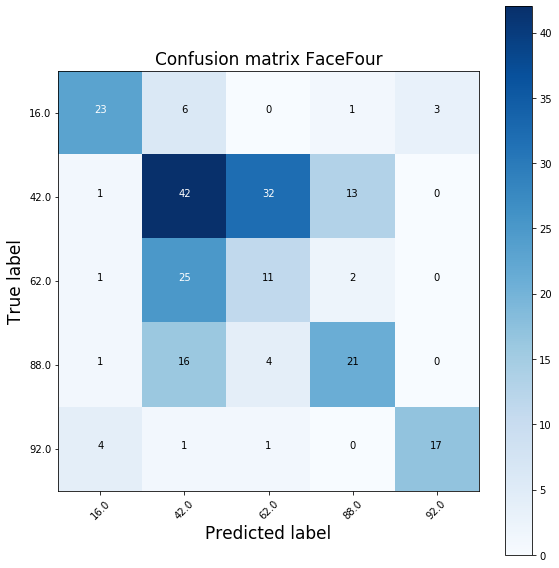

In [78]:
cnf_matrix = confusion_matrix(p_test_l, pred_labels)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=np.unique(p_test_l), normalize=False,
                      title='Confusion matrix FaceFour')

In [27]:

def local_trend(uts):
    trend_sequence = [[(uts[i] - uts[i-1]) / uts[i-1], i] for i in range(1, len(uts))]
    return trend_sequence

def segmentation(uts, threshold):
    trend_seq = local_trend(uts)
    seg_seq = []
    sign = np.sign(trend_seq[0][0])
    seg_ini = 0
    for i in range(1, len(trend_seq)):
        trend_value, trend_i = trend_seq[i]
        if trend_value == 0.0:
            trend_sign = 0
        elif trend_value >= 0.0:
            trend_sign = 1
        else:
            trend_sign = -1
#         print(trend_value, trend_sign, sign, threshold)
        if sign != trend_sign:
            if sign == 0:
                sign = trend_sign
            elif np.abs(trend_value) >= threshold:
                seg_end = trend_i
                seg_seq.append([seg_ini, seg_end])
#                 print("end segment with sign:", sign, "in range: [%d,%d]" % (seg_ini, seg_end))
                seg_ini = trend_i
                sign = trend_sign
    return seg_seq, trend_seq

def approximation(seq_seg, uts):
    approx_seq = []
    samples = []
    for i in range(len(seq_seg)):
        ini, end = seq_seg[i]
        R = (uts[end] - uts[ini]) / uts[ini]
        R_t = end
        approx_seq.append(R)
        samples.append(R_t)
    return samples, approx_seq

def reduction(seq_seg, uts):
    samples = []
    for i in range(len(seq_seg)):
        ini, end = seq_seg[i]
        samples.append(ini)
        samples.append(end)
    samples = np.sort(np.unique(samples))
    reduced_uts = [uts[i] for i in samples]
    return samples, reduced_uts

In [28]:
train_file = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TRAIN.tsv"
test_file = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TEST.tsv"

file = open(train_file, 'r')
lines = file.readlines()
dataset = []
labels = []
for d in lines:
    arr = d[:-1].split('\t')
    y = np.array(arr[1:], dtype=float)
    labels.append(arr[0])
    dataset.append(y)

file_t = open(test_file, 'r')
lines_t = file_t.readlines()
test = []
l_test = []
for d in lines_t:
    arr = d[:-1].split('\t')
    y = np.array(arr[1:], dtype=float)
    test.append(y)
    l_test.append(arr[0])


In [40]:
# fit = SimpleExpSmoothing(dataset[2]).fit(smoothing_level=0.7)
# plt.figure(figsize=(14, 3))
# plt.plot(fit.fittedvalues, label="smoothed")
# plt.plot(dataset[2], label="raw")
# plt.legend()
# plt.figure(figsize=(14, 3))
# plt.plot(fit.fittedvalues - dataset[2], label="smoothed")

In [41]:
# fit.model.params['smoothing_level']

In [42]:
# uts = dataset[5]
# uts = fit.fittedvalues

# seg_seq, trend_seq = segmentation(uts, 0.2)


# uts_reduced = [uts[0]]
# samples = [0]
# for i in range(len(seg_seq)):
#     uts_reduced.append(uts[seg_seq[i][1]])
#     samples.append(seg_seq[i][1])

# plt.plot(uts)
# plt.plot(samples, uts_reduced)

In [43]:
# t, y = approximation(seg_seq, uts)
# plt.plot(t, y)

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from t

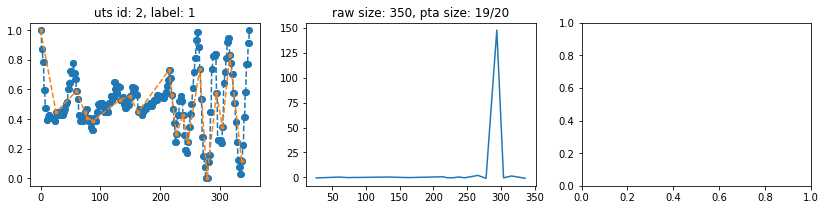

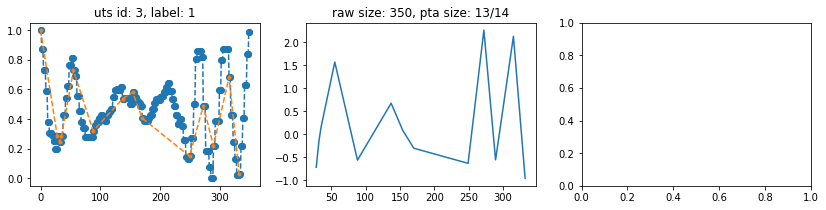

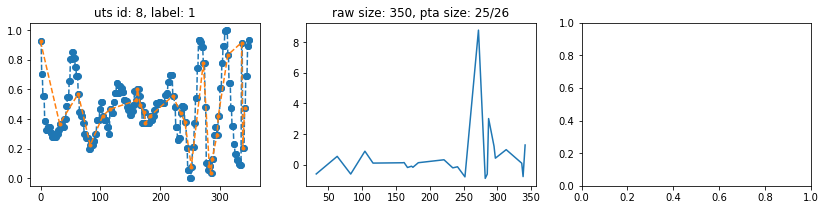

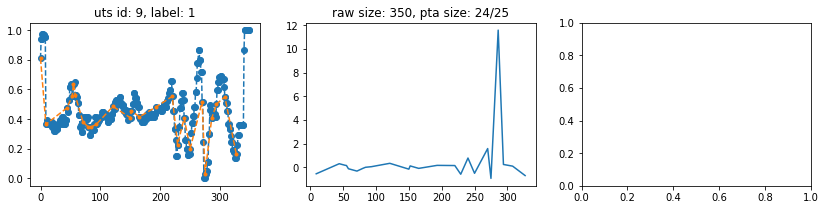

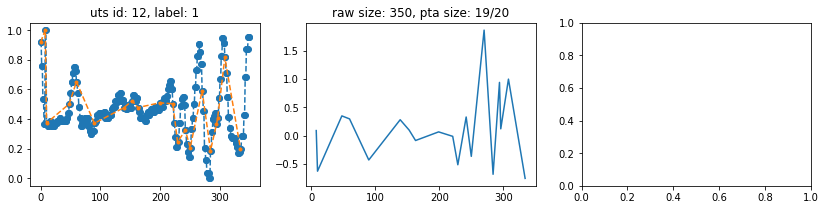

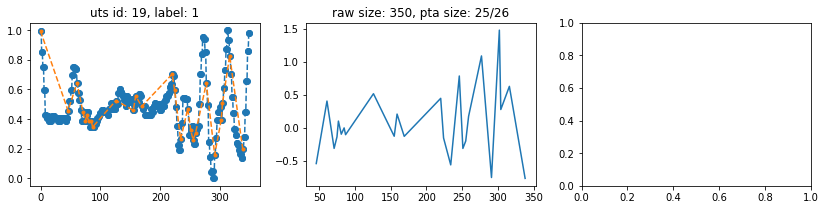

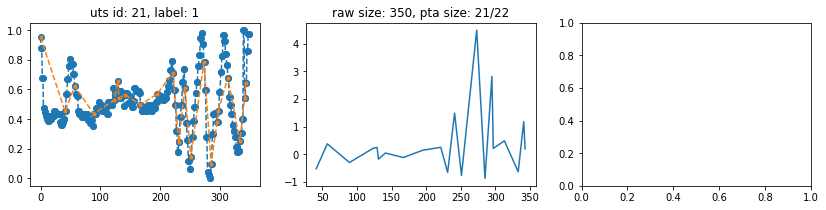

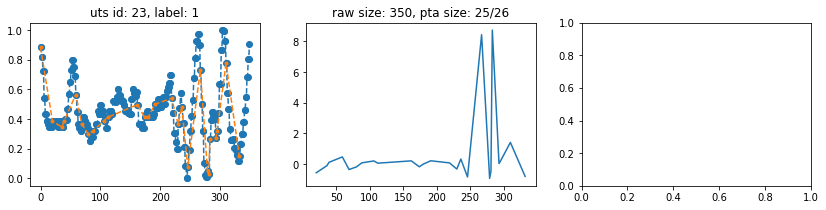

In [68]:
for j in range(len(labels)):
    if labels[j] == '1':
        uts = preprocessing.minmax_scale(dataset[j])
        seg_seq, trend_seq = segmentation(uts, 0.1)
        uts_reduced = [uts[0]]
        samples = [0]
        for i in range(len(seg_seq)):
            uts_reduced.append(uts[seg_seq[i][1]])
            samples.append(seg_seq[i][1])

        fig, ax = plt.subplots(1, 3, figsize=(14, 3))
        ax[0].plot(uts, 'o--')
#         ax[0].plot(samples, uts_reduced)

        t, y = approximation(seg_seq, uts)
        ax[1].plot(t, y)
        ax[0].set_title("uts id: " + str(j) + ", label: " + labels[j])
        
        t2, y2 = reduction(seg_seq, uts)
        ax[0].plot(t2, y2, '.--')
        ax[1].set_title("raw size: " + str(len(uts)) + ", pta size: " + str(len(y)) + "/" + str(len(y2)))

In [36]:
pta_dataset = []
pta_times = []

for j in range(len(labels)):
    uts = preprocessing.scale(dataset[j])
    seg_seq, trend_seq = segmentation(uts, 0.1)
    
#     t, y = approximation(seg_seq, uts)
    t, y = reduction(seg_seq, uts)
    pta_dataset.append(np.array(y))
    pta_times.append(t)
    
pta_test = []
pta_test_time = []

for j in range(len(l_test)):
    uts = test[j]
    seg_seq, trend_seq = segmentation(uts, 0.1)
    
#     t, y = approximation(seg_seq, uts)
    t, y = reduction(seg_seq, uts)
    pta_test.append(np.array(y))
    pta_test_time.append(t)

In [37]:
def distance_matrix(X_train, X_test):
    # compute distances between each time series on test set and train set
    n = len(X_train)
    m = len(X_test)
    res = np.ones((n, m)) * -1
    for i in range(n):
        for j in range(m):
            d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(X_train[i], X_test[j], 'euclidean')
            res[i][j] = d
    return res

def mydist(x, y):
    d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(x, y, 'euclidean')
    return d

In [38]:
%%time
dmatrix_pta = distance_matrix(pta_dataset, pta_test)

Wall time: 17 s


In [39]:
pred_labels = []
pred_labels2 = []
n = len(labels)
m = len(l_test)
for j in range(m):
    dmin = np.inf
    mink = -1
    dists = [(dmatrix_pta[ii][j], ii) for ii in range(n)]
    dists.sort(reverse=True)
    k = 10
    k_labels = defaultdict(int)
    while k >0:
        d, ii = dists.pop()
        k_labels[labels[ii]] += 1
        k -= 1
        
#     print(k_labels, l_test[j])
    
    max_label = -1
    max_value = -1
    for k, v in k_labels.items():
        if max_value < v:
            max_value = v
            max_label = k
    
    pred_labels.append(max_label)
    
    for i in range(n):
        if dmatrix_pta[i][j] < dmin:
            dmin = dmatrix_pta[i][j]
            mink = i

    pred_labels2.append(labels[mink])

balanced_acc = balanced_accuracy_score(l_test, pred_labels)
acc = accuracy_score(l_test, pred_labels)

balanced_acc2 = balanced_accuracy_score(l_test, pred_labels2)
acc2 = accuracy_score(l_test, pred_labels2)
"10NN bacc: {}, 10NN acc: {}, 1NN bacc: {}, 1NN acc: {}".format(balanced_acc, acc, balanced_acc2, acc2)

'10NN bacc: 0.5804195804195804, 10NN acc: 0.5227272727272727, 1NN bacc: 0.7574925074925075, 1NN acc: 0.7272727272727273'

In [142]:
%%time
dmatrix = distance_matrix(dataset, test)

Wall time: 7min 2s


In [157]:
pred_labels = []
n = len(labels)
m = len(l_test)
for j in range(m):
    dmin = np.inf
    mink = -1
    for i in range(n):
        if dmatrix[i][j] < dmin:
            dmin = dmatrix[i][j]
            mink = i

    pred_labels.append(labels[mink])

balanced_acc = balanced_accuracy_score(l_test, pred_labels)
acc = accuracy_score(l_test, pred_labels)
balanced_acc, acc

(0.8618881118881119, 0.8409090909090909)

1NN classification accuracy with brute force is: 84%

In [167]:
(7 * 60 + 2) / 14

30.142857142857142

In [2]:
main_path = os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), '..'))
data_path = os.path.join(main_path, "data", "plasticc_subsets", "ddf_wdf_split_simplified", "60_40_split")

train_dataset = np.load(os.path.join(data_path, "ddf_train_d_size558.npy"), allow_pickle=True)
train_times = np.load(os.path.join(data_path, "ddf_train_t_size558.npy"), allow_pickle=True)
train_labels = np.load(os.path.join(data_path, "ddf_train_l_size558.npy"), allow_pickle=True)

test_dataset = np.load(os.path.join(data_path, "ddf_test_d_size558.npy"), allow_pickle=True)
test_times = np.load(os.path.join(data_path, "ddf_test_t_size558.npy"), allow_pickle=True)
test_labels = np.load(os.path.join(data_path, "ddf_test_l_size558.npy"), allow_pickle=True)

51


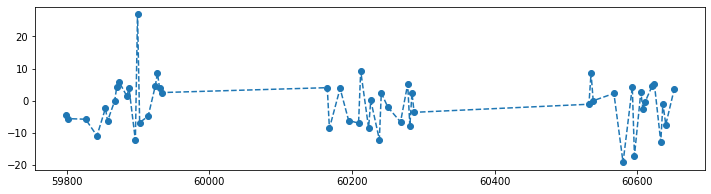

In [4]:
plt.figure(figsize=(12, 3))
plt.plot(train_times[0], train_dataset[0], 'o--')
print(len(train_dataset[0]))

In [5]:
import pdb

def local_trend2(uts, times):
    trend_sequence = [[(uts[i] - uts[i-1]) / uts[i-1], i] for i in range(1, len(uts))]
    return trend_sequence

def get_sign(v):
    if v == 0.0:
        return 0
    elif v > 0:
        return 1
    else:
        return -1

def segmentation2(uts, times, threshold):
    trend_seq = local_trend2(uts, times)
#     print(trend_seq)
    seg_seq = []
    sign = get_sign(trend_seq[0][0])
    seg_ini = 0
    seg_end = trend_seq[0][1]
    for i in range(1, len(trend_seq)):
        trend_value, trend_i = trend_seq[i]
#         if trend_i == 19:
#             pdb.set_trace()
        trend_sign = get_sign(trend_value)
#         print(trend_value, trend_sign, sign, threshold)
        if sign == trend_sign:
            seg_end = trend_i
            if i == len(trend_seq) -1:
                seg_seq.append([seg_ini, seg_end])
        else:
            if np.abs(trend_value) <= threshold:
                seg_end = trend_i
            else:
                seg_seq.append([seg_ini, seg_end])
                seg_ini = seg_end
                seg_end = trend_i
                sign = trend_sign
                
        
#         if sign != trend_sign:
#             if sign == 0:
#                 sign = trend_sign
#             elif np.abs(trend_value) >= threshold:
# #                 seg_end = trend_i
#                 seg_seq.append([seg_ini, seg_end])
#                 print("end segment with sign:", sign, "in range: [%d,%d]" % (seg_ini, seg_end))
#                 seg_ini = seg_end
#                 sign = trend_sign
        
#         seg_end = trend_i
    return seg_seq, trend_seq

def approximation2(seq_seg, uts, times):
    approx_seq = []
    samples = []
    for i in range(len(seq_seg)):
        ini, end = seq_seg[i]
        R = (uts[end] - uts[ini]) / uts[ini]
        R_t = times[end]
        approx_seq.append(R)
        samples.append(R_t)
    return samples, approx_seq

def reduction2(seq_seg, uts, times):
    samples = []
    for i in range(len(seq_seg)):
        ini, end = seq_seg[i]
        samples.append(ini)
        samples.append(end)
    samples = np.sort(np.unique(samples))
    reduced_uts = [uts[i] for i in samples]
    samples = [times[i] for i in samples]
    return samples, reduced_uts

In [60]:
jj = 0
uts = preprocessing.minmax_scale(train_dataset[jj]) + 0.1
uts_times = train_times[jj]


seq_seg, trend_seq = segmentation2(uts, uts_times, 0.1)

samples, r_uts = reduction2(seq_seg, uts, uts_times)

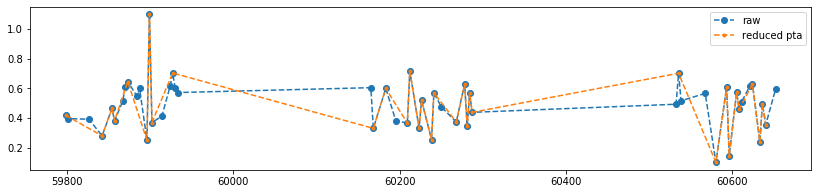

In [61]:
plt.figure(figsize=(14, 3))
plt.plot(uts_times, uts, 'o--', label="raw")
plt.plot(samples, r_uts, '.--', label="reduced pta")
plt.legend()

- normalizar series de tiempo
- parametro threshold deberia afectar al tiempo de ejecucion y accuracy final
- como aseguro que esto de un mejor resultado que fuerza bruta?
- como puedo introducir multi-band en esta representacion?
- indexacion?
- codebooks?
